In [4]:
import seaborn as sns
import numpy as np

from scipy.stats import kurtosis, skew, gaussian_kde
from scipy.signal import argrelextrema

from rcv_distribution import *
from rcv_dimensionality import *

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_learning/rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Peltola, Mary S.': 0.0, 'Bye, Chris': 0.9466134532522562, 'Begich, Nick': 2.1368619877599473, 'Palin, Sarah': 3.0}


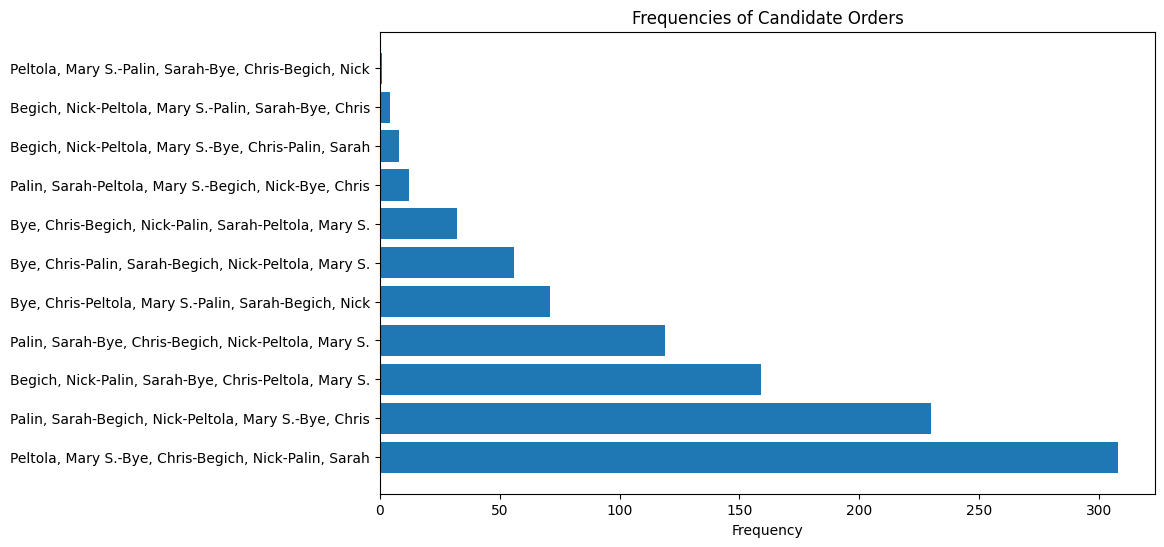

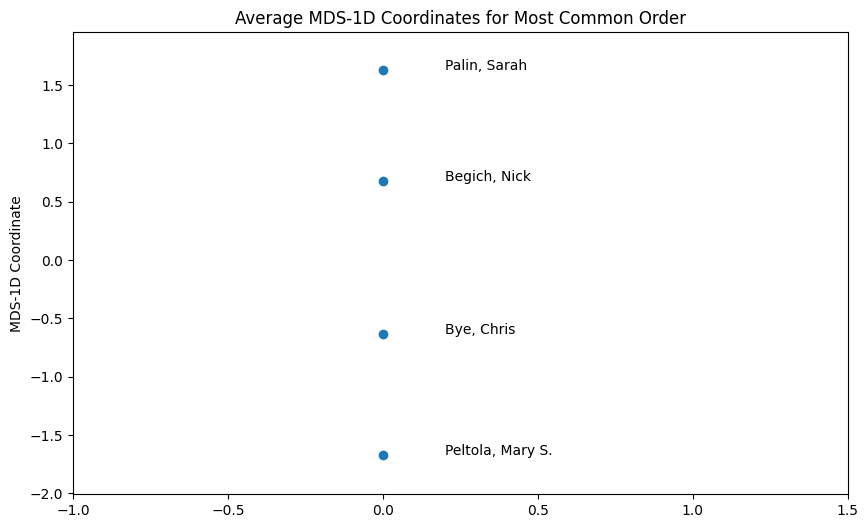

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_learning/rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Consistency points: {0.23665336331306397: 11360, 0.0: 54315, 0.3854344301265254: 6125, 0.5342154969399868: 16530, 3.0: 21392, 0.75: 1696, 0.4393805558915287: 12193, 2.203865424006499: 5926, 2.3526464908199607: 27644, 2.144702083178233: 3229, 2.1368619877599473: 12355, 0.6421077484699934: 1170, 1.2441755868791788: 380, 2.085538742349967: 1072, 0.9466134532522559: 927, 1.3520678384091853: 763, 1.1258489052226468: 180, 1.4599600899391918: 279, 1.2541855643943807: 349}
Ashman's D statistic: 2.4982673686182233
Sarle's coefficient: 0.8080161128562978


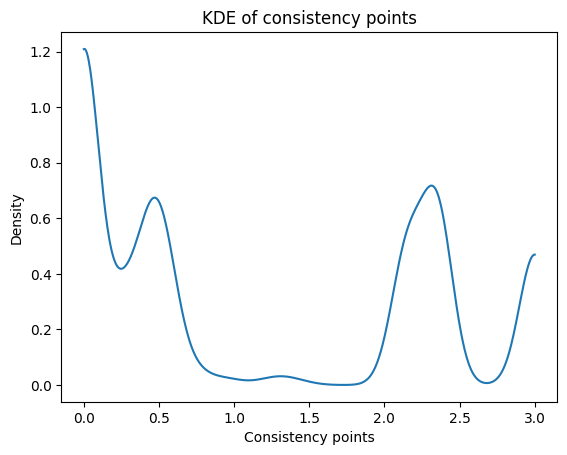

In [8]:
# Test the function with a custom CSV file
csv = "../rcv_elections_database/single/Alaska_11082022_USRepresentative.csv"

# Perform the RCV analysis
test = perform_rcv_analysis(csv, n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
print("Normalized distances:", get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

# Get the consistency points for the bimodality analysis
points = get_consistency_points(csv)
print("Consistency points:", points)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Calculate skewness and kurtosis
g = skew(data_points)
k = kurtosis(data_points)

# Calculate KDE without plotting
density = gaussian_kde(data_points)
x_vals = np.linspace(min(data_points), max(data_points), 1000)
y_vals = density(x_vals)

# Identify local maxima in the KDE
maxima_indices = argrelextrema(y_vals, np.greater)

# Get the x-values of the maxima
modes = x_vals[maxima_indices]

# Check if there are at least two modes
if len(modes) >= 2:
    mode1, mode2 = modes[:2]
else:
    mode1, mode2 = None, None

# Split the data into two groups based on proximity to the modes
data_group1 = [point for point in data_points if abs(point - mode1) < abs(point - mode2)]
data_group2 = [point for point in data_points if abs(point - mode1) > abs(point - mode2)]

# Calculate mean and variance for each group
mu1, sigma1_sq = np.mean(data_group1), np.var(data_group1)
mu2, sigma2_sq = np.mean(data_group2), np.var(data_group2)

# Calculate Ashman's D statistic (D > 2)
ashmans_D = abs(mu1 - mu2) / np.sqrt((sigma1_sq + sigma2_sq) / 2)
print("Ashman's D statistic:", ashmans_D)

# Calculate Sarle's bimodality coefficient b (b > 5/9)
n = len(data_points)
sarle = (g**2 + 1) / (k + 3 * (n-1)**2 / ((n-2) * (n-3)))
print("Sarle's coefficient:", sarle)

# Calculate Hartigan's dip statistic ...


# Plot the KDE
plt.plot(x_vals, y_vals)
plt.title("KDE of consistency points")
plt.xlabel("Consistency points")
plt.ylabel("Density")
plt.show()

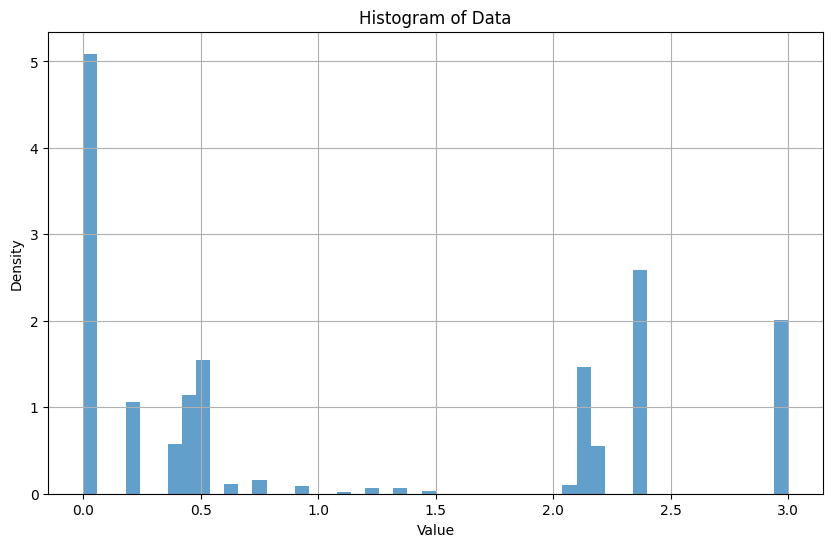

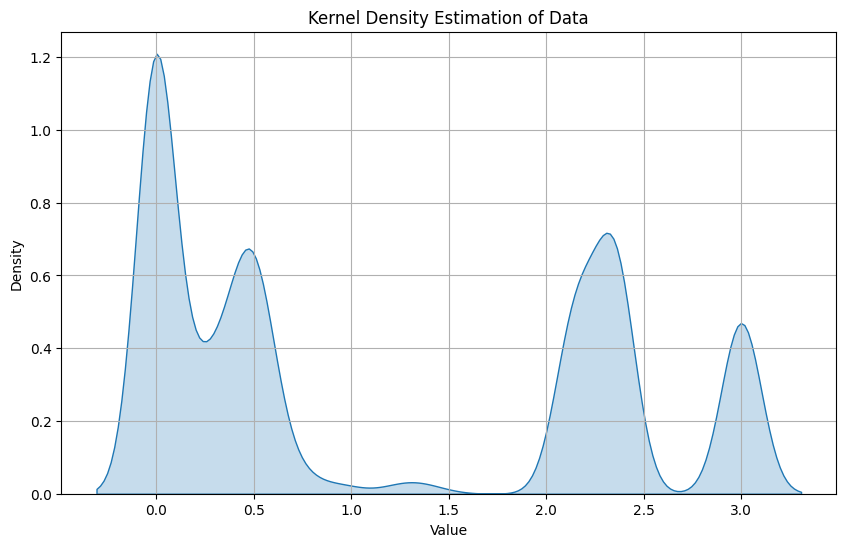

In [6]:
# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()